In [1]:
import os 
cwd = os.getcwd()
import sys
sys.path.append("C:/Users/gomel/Documents/global_python_codes/Metrics_thresholds_boots") # go to parent dir
import sympy as sp
import ewstools as ews
import numpy as np
import sdeint
import metrics
import boots as bts
import scipy.stats as st
import astropy.stats as astrost
import scipy.signal as sg

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})

try:
    os.mkdir('./skipping')
except: print('Folder exists')

try:
    os.mkdir('./skipping/hist')
except: print('Folder exists')

try:
    os.mkdir('./skipping/lags')
except: print('Folder exists')

Folder exists
Folder exists
Folder exists


This is a simulation of a onlinear equation with aditive noise using a Heun method where the noise only applies on the variable and not the parameter. 

\begin{equation}
\dot{x}=-\lambda x
\end{equation}

where $x$ is a random variable and $\lambda$ is a swiped parameter determined by $\dot{\lambda}=\lambda$.  


This system has three fixed points, $x^*={0}$.

In this case, the initial condition is always around the same point, but stil, i'll use the last value the previous integration and wait $t=2t^*$ 


0.041666666666666664
$\Delta t= $ 0.041666666666666664 t_final: 240.0
data length:  5760
lambda:  3.0
lambda:  2.5477663450375516
lambda:  2.163704449635335
lambda:  1.8375377924629681
lambda:  1.5605389817905826
lambda:  1.3252962326417383
lambda:  1.1255150462432262
lambda:  0.9558497852172918
lambda:  0.8117606378959961
lambda:  0.6893921444858777
lambda:  0.5854700347514615
lambda:  0.4972136168559132
lambda:  0.4222613731066305
lambda:  0.35860777173680586
lambda:  0.3045496039666476
lambda:  0.2586404104602465
lambda:  0.21965177774577144
lambda:  0.18654046898944823
lambda:  0.15842050962627907
lambda:  0.13453948092984383
lambda:  0.11425838719729248
lambda:  0.09703455784651044
lambda:  0.08240712692897963
lambda:  0.06998470152696397
lambda:  0.059434889072632335
lambda:  0.05047540336676428
lambda:  0.04286651131667903
lambda:  0.03640461828726874
lambda:  0.030916820425413976
lambda:  0.02625627819181308
lambda:  0.022298287307681602
lambda:  0.018936941984829717
lambda:  0

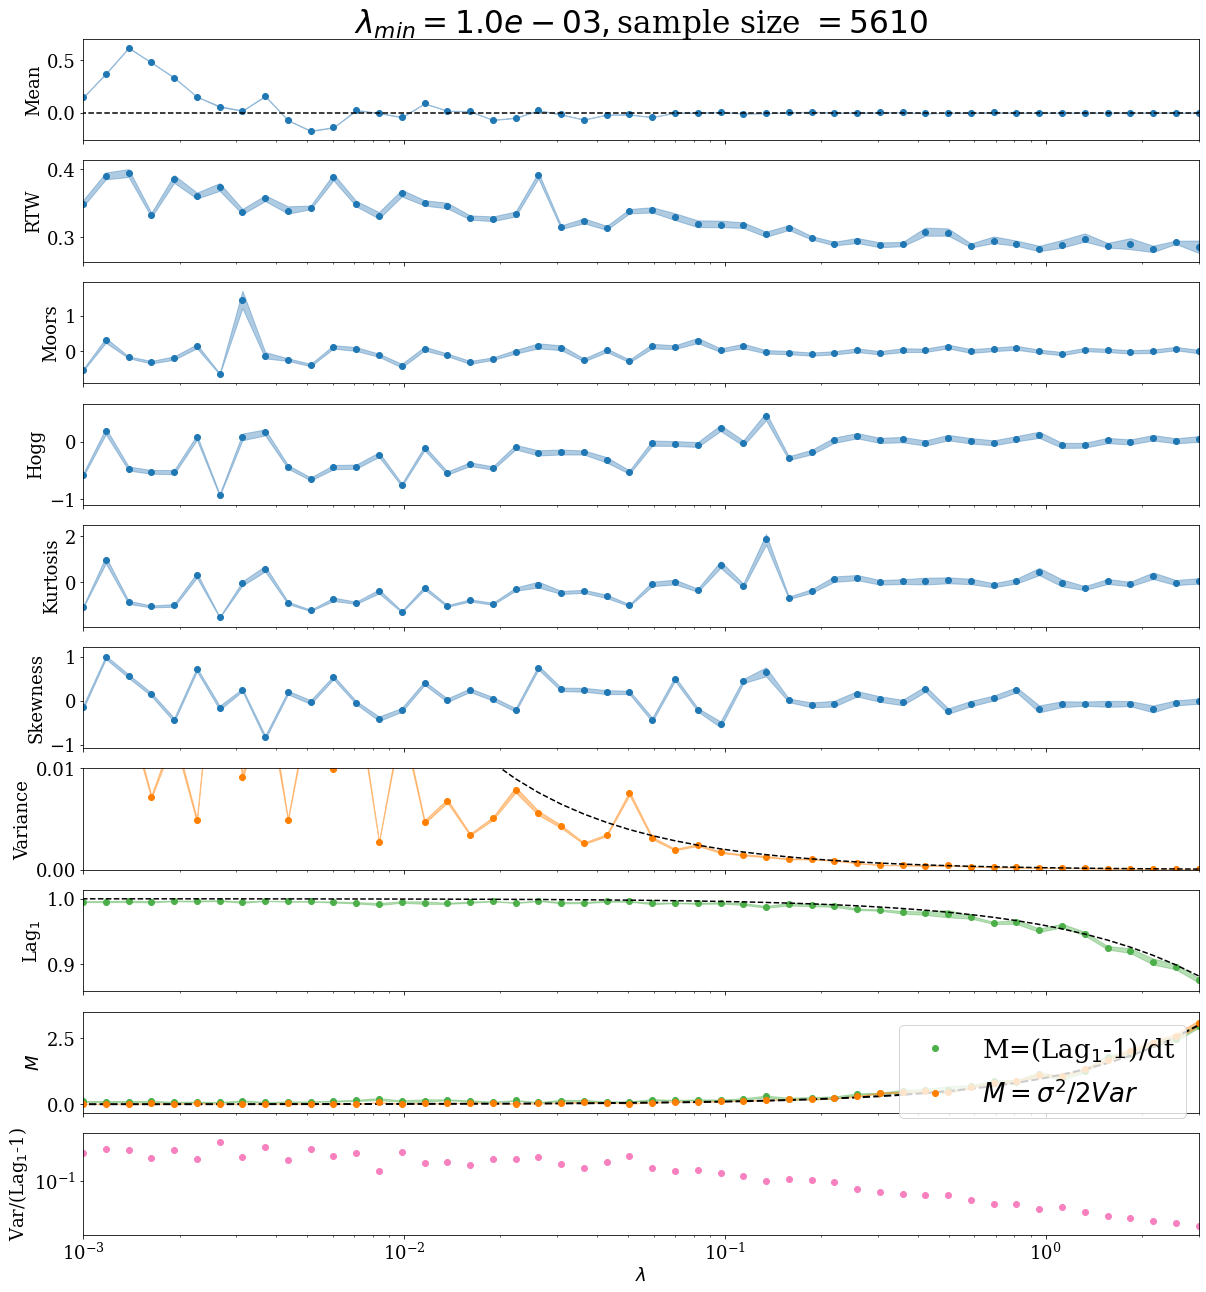

In [2]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

s=0.02 #noise process intensity
B = np.diag([s]) # diagonal, so independent driving Wiener processes

l0=3 #Initial lambda
lf=.001 #Final lambda
l_var=np.linspace(l0,lf,100)
l_var=np.logspace(np.log(l0),np.log(lf),50,base=np.e)
l=l_var[0]

def f(x, t):
    #X=x[0]. dot(x)=rx-x^3
    #r=x[1]. dot(r)=cte.  This is a constant swipe of parameter r at speed dot(r). 
    A=np.array([ -l*x[0] ])
    return A
def G(x, t):
    #B=[ 'noise in x'         0    ]
    #  [      0        'noise in r']
    #the only parameter with relevant aditive noise is X(t) in this case. 
    return B  

np.random.seed(1) #set numpy.random seed for reproducibility whenever it might be used.

t_rm=1/l0
t_threshold=t_rm/2
dt=t_threshold/4

t_win=t_rm/dt ### lendth of correlation. 

datalen=dt

t_final=np.max([800*datalen,t_win*30]) ##400 correlations lenghts to recover the good data.
tspan=np.arange(0,t_final,datalen)
print(datalen)
print(r'$\Delta t= $', tspan[1]-tspan[0], 't_final:', t_final)
print('data length: ', len(tspan))

######################## pre-set varaibles ###############################
dlen=len(l_var)
mean=np.zeros([dlen])
var=np.zeros([dlen])
skew=np.zeros([dlen])
kur=np.zeros([dlen])
hogg2=np.zeros([dlen])
moors=np.zeros([dlen])
RTW=np.zeros([dlen])
ac1=np.zeros([dlen])
ac2=np.zeros([dlen])

mean_b=np.zeros([dlen,2])
var_b=np.zeros([dlen,2])
skew_b=np.zeros([dlen,2])
kur_b=np.zeros([dlen,2])
hogg2_b=np.zeros([dlen,2])
moors_b=np.zeros([dlen,2])
RTW_b=np.zeros([dlen,2])
ac1_std=np.zeros([dlen,2])
RTWh=np.zeros([dlen])
RTWl=np.zeros([dlen])
RTWh_b=np.zeros([dlen,2])
RTWl_b=np.zeros([dlen,2])
RTWc=np.zeros([dlen])+1j*np.zeros([dlen])
RTWc_b=np.zeros([dlen,2])+1j*np.zeros([dlen,2])



veq=s**2/(2*l_var)
pltlim=np.sqrt(np.max(veq))    

############################################################ integrations #######################
#initial condition is random with the equilibrium variance so all points don't start toghether:
x0= np.array([np.random.normal(0.,np.sqrt(s**2/(2*l)))]) 


for j in range(len(l_var)):
    l=l_var[j]

    def f(x, t): 
        A=np.array([ -l*x[0] ])
        return A
    
    result = sdeint.stratHeun(f, G, x0, tspan)
    x0=np.array([result[-1,0]])#update final value

    np.array(result[-1,0])#update final value
    
    t_transit=150

    n_resample_case=500 #Bootstraping re-samples
    sample_perc=70 #Bootstraping percentile
    res=result[t_transit:-1,0]
    #single shot variance bootstraping
    vr_b = bts.boot_result(bts.blockbootstrap(np.var,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    var[j]= vr_b[0]
    var_b[j]=vr_b[1][0],vr_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(st.skew,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    skew[j]= sk_b[0]
    skew_b[j]=sk_b[1][0],sk_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(np.mean,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    mean[j]= sk_b[0]
    mean_b[j]=sk_b[1][0],sk_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(st.kurtosis,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    kur[j]= sk_b[0]
    kur_b[j]=sk_b[1][0],sk_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(metrics.RTW_max,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    RTW[j]= sk_b[0]
    RTW_b[j]=sk_b[1][0],sk_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(metrics.RTW_high,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    RTWh[j]= sk_b[0]
    RTWh_b[j]=sk_b[1][0],sk_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(metrics.RTW_low,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    RTWl[j]= sk_b[0]
    RTWl_b[j]=sk_b[1][0],sk_b[1][1]
    RTWc=RTWh+1j*RTWl
    try:
        sk_b = bts.boot_result(bts.blockbootstrap(metrics.Hogg2,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
        hogg2[j]= sk_b[0]
        hogg2_b[j]= sk_b[1][0],sk_b[1][1]
        sk_b = bts.boot_result(bts.blockbootstrap(metrics.Moors,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
        moors[j]= sk_b[0]
        moors_b[j]= sk_b[1][0],sk_b[1][1]
    except:
        continue
  
        
    varwin=0.5
   # 15*t_win/t_final
    ts = ews.TimeSeries(data=res)  ### ews stats ### 
    ts.detrend(method='Gaussian',bandwidth=varwin/2, span=varwin/2)
    ts.compute_auto(lag=1,rolling_window=varwin)
    ts.compute_auto(lag=2,rolling_window=varwin)
    ts.compute_var(rolling_window=varwin)
    ac_labels = [s for s in ts.ews.columns if s[:2]=='ac']
   # smooth=ts.state['smoothing'].values
    ac1[j]=np.nanmean(ts.ews[ac_labels[0]].values)
    ac2[j]=np.nanmean(ts.ews[ac_labels[1]].values)

    ac1_std[j]=np.sqrt(np.nanvar(ts.ews[ac_labels[0]].values)),np.sqrt(np.nanvar(ts.ews[ac_labels[0]].values))
    #ts.compute_ktau()

    var_ews=ts.ews['variance'].values

    fig=plt.figure(figsize=(20,10))
    fig.add_subplot(211)
    
    plt.title(r'$\lambda = %.1e, sample size = %.i$' %(l,len(tspan)-t_transit))
    plt.plot(tspan,result)
    plt.plot(tspan[t_transit:-1],res)
    plt.plot(tspan,0*tspan+np.sqrt(s**2/(2*l)),'--',color='black')
    plt.plot(tspan,0*tspan-np.sqrt(s**2/(2*l)),'--',color='black')
    plt.plot(tspan,0*result,'-',color='black')
    plt.ylabel('$x$')
    plt.xlabel('$t$')
    plt.ylim([-1.1*pltlim,1.1*pltlim ])

    fig.add_subplot(212)
    plt.hist(result,bins=100)
    plt.ylabel('$x$')
    plt.xlim([-2*pltlim,2*pltlim ])
    fig.savefig(str('./skipping/hist/%.3i' %(j))+'single_wel_skip_trayectory.png'  , dpi = 100)# when saving, specify the DPI\n",
    plt.close(fig)

    fig=plt.figure(figsize=(20,10))
    fig.add_subplot(211)
    plt.plot(ts.ews[ac_labels[0]].values)
    fig.add_subplot(212)
    plt.hist(ts.ews[ac_labels[0]].values,bins=50)
    plt.ylabel('$x$')
    plt.xlim([0.5,1.1])
    fig.savefig(str('./skipping/lags/%.3i' %(j))+'lag_1.png'  , dpi = 100)# when saving, specify the DPI\n",
    plt.close(fig)  

    print('lambda: ', l)

   #Mac=-(ac1-1)/dt
#vac=-var_ews/(ac1-1)
#Mvar=-s**2/(2*var)

##################################### print stats ##############################################    
fig, ax = plt.subplots(10, 1, sharex='col',figsize=(20,22))
plt.rc('font',size=25)

#plt.subplots(2)
axs=ax[0]
axs.set_title(r'$\lambda_{min} = %.1e, $sample size $= %.i$' %(l,len(tspan)-t_transit))
axs.plot(l_var,mean,'o',label='mean')
axs.set_ylabel('Mean')
axs.fill_between(l_var, mean_b[:,0], mean_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.plot(l_var,0*veq,'--',color='black')
axs=ax[6]
axs.plot(l_var,var,'o',color=CB_color_cycle[1],label='Variance')
axs.fill_between(l_var, var_b[:,0], var_b[:,1], color=CB_color_cycle[1], alpha=.4)
axs.plot(l_var,veq,'--',color='black')
axs.set_ylabel('Variance')
axs.set_ylim([0,0.01])
axs=ax[5]
axs.plot(l_var,skew,'o',label='skewness')
axs.fill_between(l_var, skew_b[:,0],skew_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel('Skewness')
axs=ax[4]
axs.plot(l_var,kur,'o',label='Kurtosis')
axs.fill_between(l_var, kur_b[:,0], kur_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel('Kurtosis')
axs=ax[7]
axs.plot(l_var,ac1,'o', color=CB_color_cycle[2],label='Mean Autocorrelation')
axs.fill_between(l_var, ac1+ac1_std[:,0], ac1-ac1_std[:,1], color=CB_color_cycle[2], alpha=.4)
axs.plot(l_var,np.exp(-l_var*dt),'--',color='black',label='Lag-1')
axs.set_ylabel('Lag$_1$')
axs=ax[8]
axs.plot(l_var,-(ac1-1)/dt,'o', color=CB_color_cycle[2],label='M=(Lag$_1$-1)/dt')
axs.plot(l_var,l_var,'--',color='black',linewidth=2)
axs.fill_between(l_var, -(ac1+ac1_std[:,0]-1)/dt, -(ac1-ac1_std[:,1]-1)/dt, color=CB_color_cycle[2], alpha=.4)
axs.plot(l_var,s**2/(2*var),'o',color=CB_color_cycle[1],label='$M=\sigma^2/2Var$')
axs.fill_between(l_var, s**2/(2*var_b[:,0]), s**2/(2*var_b[:,1]), color=CB_color_cycle[1], alpha=.4)
axs.legend(loc="upper right")
axs.set_ylabel(r'$M$')
#plt.legend()
axs=ax[1]
axs.plot(l_var,RTW,'o',label='RTW')
axs.fill_between(l_var, RTW_b[:,0],RTW_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel(r'RTW')
axs=ax[3]
axs.plot(l_var,hogg2,'o',label='RTW')
axs.fill_between(l_var, hogg2_b[:,0],hogg2_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel(r'Hogg')
axs=ax[2]
axs.plot(l_var,moors,'o',label='kur3')
axs.fill_between(l_var, moors_b[:,0],moors_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel(r'Moors')
axs=ax[9]
axs.plot(l_var,-var/(ac1-1),'o', color=CB_color_cycle[3],label='M=(Lag$_1$-1)/dt')
axs.set_ylabel('Var/(Lag$_1$-1)')
axs.set_yscale('log')

for xx in ax:
    yl=xx.get_ylim()
    xx.plot([0,0],yl,'-',color='gray',linewidth=4)
    xx.set_xlim([min(l_var),3.01])
axs.set_xscale('log')
axs.set_xlabel('$\lambda$')
plt.rc('font',size=25)

fig.savefig(str('./skipping/')+'stats5.png'  , dpi = 200,bbox_inches='tight')# when saving, specify the DPI\n",

In [28]:
##################################### print stats ##############################################    
fig, ax = plt.subplots(6, 2, sharex='col',figsize=(20,22))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font',size=25)
plt.subplots_adjust(hspace=0.05)#plt.subplots(2)
axs=ax[0,0]
axs.plot(l_var,RTW,'o',label='RTW')
axs.fill_between(l_var, RTW_b[:,0],RTW_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel(r'RTW ')
axs.set_xlabel(r'$\lambda$')
axs.set_title(r'$\sigma = %.1e, sample size = %.i$' %(s,len(tspan)-t_transit))
axs=ax[1,0]
axs.plot(l_var,moors,'o',label='kur3')
axs.fill_between(l_var, moors_b[:,0],moors_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel(r'Moors')
axs=ax[2,0]
axs.plot(l_var,hogg2,'o',label='RTW')
axs.fill_between(l_var, hogg2_b[:,0],hogg2_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel(r'Hogg')
axs=ax[3,0]
axs.plot(l_var,kur,'o',label='Kurtosis')
axs.fill_between(l_var, kur_b[:,0], kur_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel('Kurtosis')
axs=ax[4,0]
axs.plot(l_var,skew,'o',label='skewness')
axs.fill_between(l_var, skew_b[:,0],skew_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel('Skewness')

axs=ax[0,1]
axs.plot(l_var,ac1,'o', color=CB_color_cycle[2],label='Lag$_1$')
axs.fill_between(l_var, ac1+ac1_std[:,0], ac1-ac1_std[:,1], color=CB_color_cycle[2], alpha=.4)
axs.plot(l_var,ac2,'o', color=CB_color_cycle[4],label='Lag$_2$')
axs.plot(l_var,np.exp(-l_var*dt),'--',color='black')
axs.plot(l_var,np.exp(-l_var*(2*dt)),'--',color='black')
axs.legend()
axs.set_ylabel('Autocorrelation')
axs=ax[1,1]
axs.plot(l_var,var,'o',color=CB_color_cycle[1],label='Variance')
axs.fill_between(l_var, var_b[:,0], var_b[:,1], color=CB_color_cycle[1], alpha=.4)
axs.plot(l_var,veq,'--',color='black')
axs.set_ylabel('Variance')
axs.set_ylim([0,0.01])
axs=ax[2,1]
axs.plot(l_var,(ac1-1)/dt,'o', color=CB_color_cycle[2],label='$M=-(AC_{1}-1)/ \Delta t$')
axs.plot(l_var,-l_var,'--',color='black',linewidth=2)
axs.fill_between(l_var, (ac1+ac1_std[:,0]-1)/dt, (ac1-ac1_std[:,0]-1)/dt, color=CB_color_cycle[2], alpha=.4)
axs.plot(l_var,-s**2/(2*var),'o', color=CB_color_cycle[1],label='$M=-\sigma^2/2Var$')
axs.set_ylabel(r'M')
axs.legend()
#plt.legend()
axs=ax[3,1]
axs.plot(l_var,var/(ac1-1),'-o',color=CB_color_cycle[3],linewidth=2)
axs.set_ylabel('$Var/AC_{1}$')
axs=ax[4,1]
axs.plot(l_var,ac1/ac2,'-o',color=CB_color_cycle[3],linewidth=2)
axs.set_ylabel('$Lag$_{1}$/Lag$_{2}$')
axs=ax[5,1]
axs.plot(l_var,mean,'o', color='black',label='mean')
axs.set_ylabel('Mean')
axs.fill_between(l_var, mean_b[:,0], mean_b[:,1], color='gray')
axs.plot(l_var,0*veq,'--',color='black')

fig.delaxes(ax[5,0])
for xx in ax.ravel():
    yl=xx.get_ylim()
    xx.plot([-0.001,-0.001],yl,'-',color='gray',linewidth=4,alpha=0.8)
    xx.set_xlim([-0.01,3.01])
plt.rc('font',size=25)

fig.savefig(str('./skipping/')+'stats2.png'  , dpi = 100)# when saving, specify the DPI\n",

RuntimeError: latex was not able to process the following string:
b'$Lag$_{1}$/Lag$_{2}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.24 (MiKTeX 22.7) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(../2d2ba31cf1adfaa0a47ddd1301aa7ea4.tex
LaTeX2e <2022-06-01> patch level 5
L3 programming layer <2022-07-04>
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))

(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty) (C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file 2d2ba31cf1adfaa0a47ddd1301aa7ea4.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
<recently read> }
                 
l.18 {\rmfamily $Lag$_{1}$/Lag$_{2}$}
                                     
No pages of output.
Transcript written on 2d2ba31cf1adfaa0a47ddd1301aa7ea4.log.




RuntimeError: latex was not able to process the following string:
b'$Lag$_{1}$/Lag$_{2}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.24 (MiKTeX 22.7) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(../2d2ba31cf1adfaa0a47ddd1301aa7ea4.tex
LaTeX2e <2022-06-01> patch level 5
L3 programming layer <2022-07-04>
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))

(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty) (C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Users\gomel\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file 2d2ba31cf1adfaa0a47ddd1301aa7ea4.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
<recently read> }
                 
l.18 {\rmfamily $Lag$_{1}$/Lag$_{2}$}
                                     
No pages of output.
Transcript written on 2d2ba31cf1adfaa0a47ddd1301aa7ea4.log.




<Figure size 1440x1584 with 11 Axes>

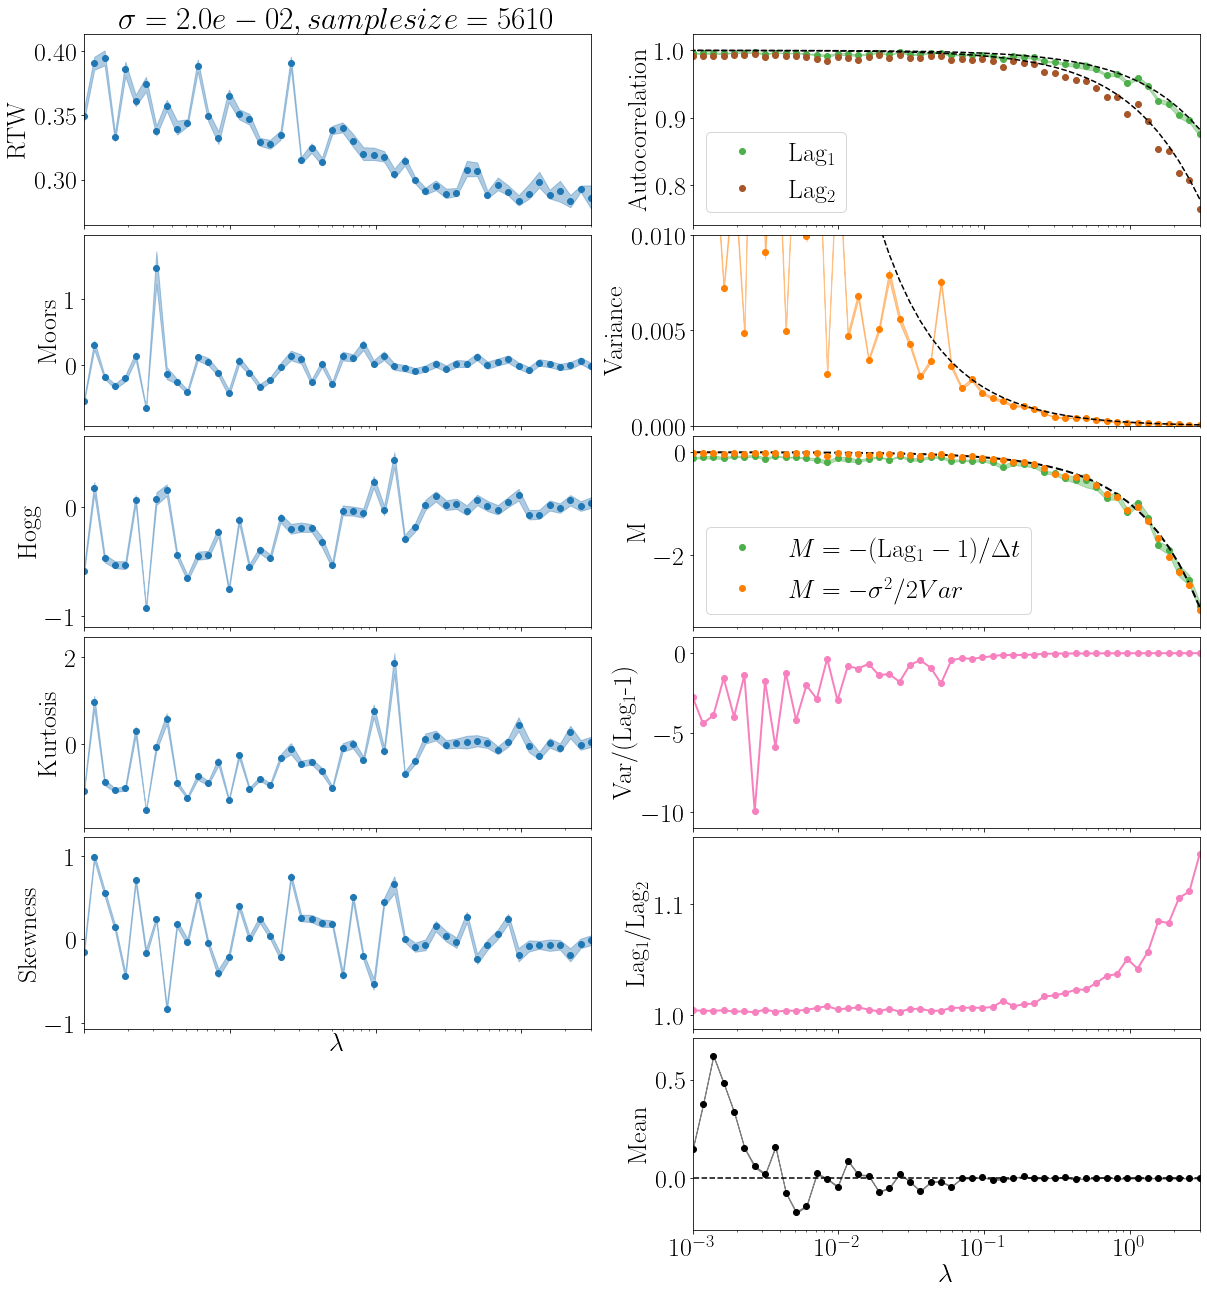

In [4]:
##################################### print stats ##############################################    
fig, ax = plt.subplots(6, 2, sharex='col',figsize=(20,22))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font',size=26)
plt.subplots_adjust(hspace=0.05)#plt.subplots(2)
axs=ax[0,0]
axs.plot(l_var,RTW,'o',label='RTW')
axs.fill_between(l_var, RTW_b[:,0],RTW_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel(r'RTW')
axs.set_title(r'$\sigma = %.1e, sample size = %.i$' %(s,len(tspan)-t_transit))
axs=ax[1,0]
axs.plot(l_var,moors,'o',label='kur3')
axs.fill_between(l_var, moors_b[:,0],moors_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel(r'Moors')
axs=ax[2,0]
axs.plot(l_var,hogg2,'o',label='RTW')
axs.fill_between(l_var, hogg2_b[:,0],hogg2_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel(r'Hogg')
axs=ax[3,0]
axs.plot(l_var,kur,'o',label='Kurtosis')
axs.fill_between(l_var, kur_b[:,0], kur_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel('Kurtosis')
axs=ax[4,0]
axs.plot(l_var,skew,'o',label='skewness')
axs.fill_between(l_var, skew_b[:,0],skew_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel('Skewness')

axs.set_xlabel('$\lambda$')
axs.set_xscale('log')

axs=ax[0,1]
axs.plot(l_var,ac1,'o', color=CB_color_cycle[2],label='Lag$_1$')
axs.fill_between(l_var, ac1+ac1_std[:,0], ac1-ac1_std[:,1], color=CB_color_cycle[2], alpha=.4)
axs.plot(l_var,ac2,'o', color=CB_color_cycle[4],label='Lag$_2$')
axs.plot(l_var,np.exp(-l_var*dt),'--',color='black')
axs.plot(l_var,np.exp(-l_var*(2*dt)),'--',color='black')
axs.legend()
axs.set_ylabel('Autocorrelation')
axs=ax[1,1]
axs.plot(l_var,var,'o',color=CB_color_cycle[1],label='Variance')
axs.fill_between(l_var, var_b[:,0], var_b[:,1], color=CB_color_cycle[1], alpha=.4)
axs.plot(l_var,veq,'--',color='black')
axs.set_ylabel('Variance')
axs.set_ylim([0,0.01])
axs=ax[2,1]
axs.plot(l_var,(ac1-1)/dt,'o', color=CB_color_cycle[2],label='$M=-($Lag$_{1}-1)/ \Delta t$')
axs.plot(l_var,-l_var,'--',color='black',linewidth=2)
axs.fill_between(l_var, (ac1+ac1_std[:,0]-1)/dt, (ac1-ac1_std[:,0]-1)/dt, color=CB_color_cycle[2], alpha=.4)
axs.plot(l_var,-s**2/(2*var),'o', color=CB_color_cycle[1],label='$M=-\sigma^2/2Var$')
axs.set_ylabel(r'M')
axs.legend()
#plt.legend()
axs=ax[3,1]
axs.plot(l_var,var/(ac1-1),'-o',color=CB_color_cycle[3],linewidth=2)
axs.set_ylabel('Var/(Lag$_{1}$-1)')
axs=ax[4,1]
axs.plot(l_var,ac1/ac2,'-o',color=CB_color_cycle[3],linewidth=2)
axs.set_ylabel('Lag$_{1}$/Lag$_{2}$')
axs=ax[5,1]
axs.plot(l_var,mean,'o', color='black',label='mean')
axs.set_ylabel('Mean')
axs.fill_between(l_var, mean_b[:,0], mean_b[:,1], color='gray')
axs.plot(l_var,0*veq,'--',color='black')
axs.set_xlabel('$\lambda$')

fig.delaxes(ax[5,0])
for xx in ax.ravel():
    yl=xx.get_ylim()
    xx.plot([-0.001,-0.001],yl,'-',color='gray',linewidth=4,alpha=0.8)
    xx.set_xlim([min(l_var),3.01])
plt.rc('font',size=26)
axs.set_xscale('log')

fig.savefig(str('./skipping/')+'stats2log.png'  , dpi = 100)# when saving, specify the DPI\n",

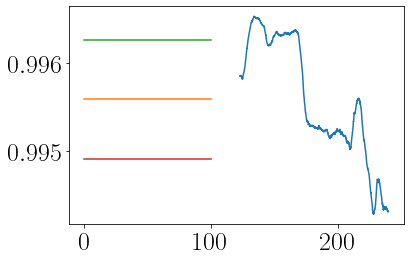

In [5]:
plt.plot(tspan[t_transit:-1],ts.ews[ac_labels[0]].values)
acmean=np.nanmean(ts.ews[ac_labels[0]].values),
plt.plot([0,100],[acmean,acmean])
acvar=np.sqrt(np.nanvar(ts.ews[ac_labels[0]].values))
plt.plot([0,100],[acmean+acvar,acmean+acvar])
plt.plot([0,100],[acmean-acvar,acmean-acvar])



In [6]:
ts = ews.TimeSeries(data=res)  ### ews stats ### 
ts


In [7]:
varwin=15*t_win/t_final
ts = ews.TimeSeries(data=res)  ### ews stats ### 
ts.detrend(method='Gaussian', span=varwin)
ts.compute_auto(rolling_window=varwin)
ts.compute_var(rolling_window=varwin)
ac_labels = [s for s in ts.ews.columns if s[:2]=='ac']
# smooth=ts.state['smoothing'].values
ac1[j]=np.nanmean(ts.ews[ac_labels[0]].values)
ac1_std[j]=np.sqrt(np.nanvar(ts.ews[ac_labels[0]].values)),np.sqrt(np.nanvar(ts.ews[ac_labels[0]].values))



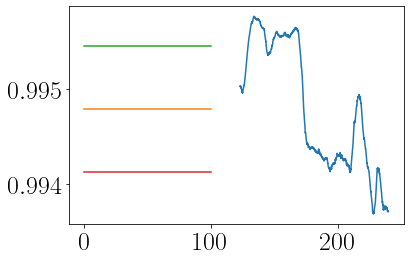

In [8]:
plt.plot(tspan[t_transit:-1],ts.ews[ac_labels[0]].values)
acmean=np.nanmean(ts.ews[ac_labels[0]].values),
plt.plot([0,100],[acmean,acmean])
acvar=np.sqrt(np.nanvar(ts.ews[ac_labels[0]].values))
plt.plot([0,100],[acmean+acvar,acmean+acvar])
plt.plot([0,100],[acmean-acvar,acmean-acvar])



In [9]:
len(tspan[t_transit:-1])

5609

In [10]:
varwin=0.5
rw=0.4
# 15*t_win/t_final
ts = ews.TimeSeries(data=res)  ### ews stats ### 
ts.detrend(method='Gaussian',bandwidth=varwin/2, span=varwin/2)
ts.compute_auto(lag=2,rolling_window=varwin)
ts.compute_var(rolling_window=varwin)
ac_labels = [s for s in ts.ews.columns if s[:2]=='ac']
# smooth=ts.state['smoothing'].values
ac1[0]=np.nanmean(ts.ews[ac_labels[0]].values)
ac1_std[0]=np.sqrt(np.nanvar(ts.ews[ac_labels[0]].values)),np.sqrt(np.nanvar(ts.ews[ac_labels[0]].values))


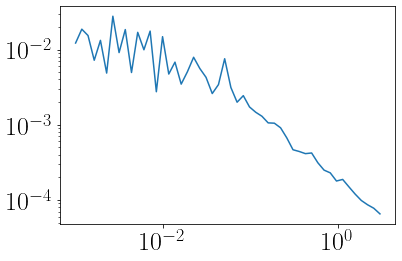

In [11]:
plt.figure()
plt.loglog(l_var, var)

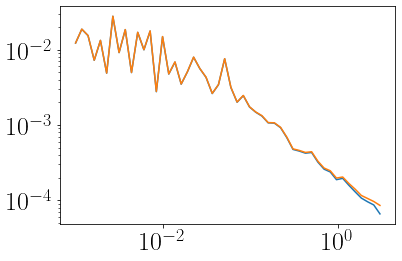

In [12]:
plt.figure()
plt.loglog(l_var, var/ac1)
plt.loglog(l_var, var/ac2)

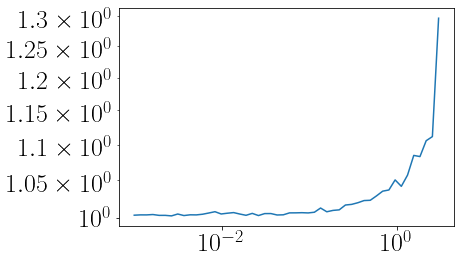

In [13]:
plt.figure()
plt.loglog(l_var, ac1/ac2)

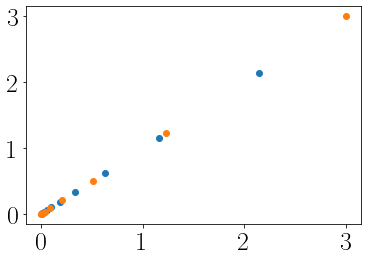

In [14]:
lg=np.logspace(np.log(3),np.log(0.001),10,base=2.0)
plt.plot(lg,lg,'o')
lg=np.logspace(np.log10(3),np.log10(0.001),10,base=10.0)
plt.plot(lg,lg,'o')

Text(0, 0.5, '|RTWc|')

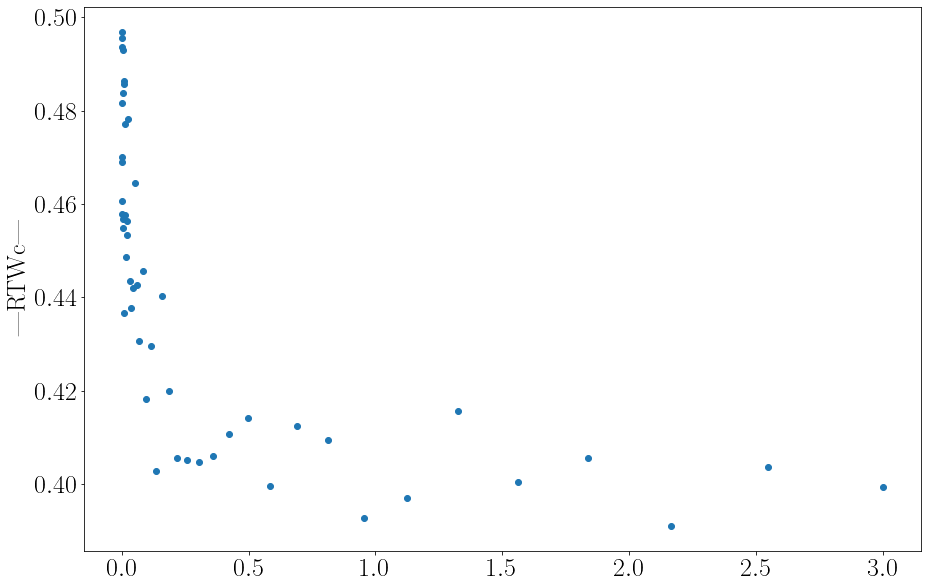

In [15]:
absrtc=np.abs(RTWc)
fig=plt.figure(figsize=(15,10))
axs=fig.add_subplot(111)
axs.plot(l_var,absrtc,'o',label='RTW')
#axs.fill_between(l_var, hogg2_b[:,0],hogg2_b[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel(r'|RTWc|')

In [16]:
RTWc


array([0.28204052+0.28273443j, 0.27812843+0.29266887j,
       0.2698357 +0.2829554j , 0.28363952+0.28977885j,
       0.27818289+0.28809524j, 0.28981086+0.29795523j,
       0.27193696+0.28914406j, 0.27210058+0.28321391j,
       0.28959451+0.2894422j , 0.2954782 +0.28764327j,
       0.27731172+0.28782964j, 0.27850317+0.30650809j,
       0.30734425+0.27230688j, 0.28934484+0.28480229j,
       0.28409306+0.288268j  , 0.29532798+0.27738919j,
       0.28280901+0.29079508j, 0.29935164+0.2943981j ,
       0.30835891+0.31420281j, 0.30442306+0.26363601j,
       0.31787707+0.28888804j, 0.27058346+0.31896908j,
       0.31034178+0.31980102j, 0.3296169 +0.27704225j,
       0.28310386+0.34026137j, 0.3386346 +0.31784443j,
       0.31249916+0.3126965j , 0.32417998+0.29406481j,
       0.3144118 +0.3128388j , 0.39087682+0.27561636j,
       0.30622939+0.3343921j , 0.32741629+0.31792866j,
       0.32916819+0.30481651j, 0.34681006+0.32766086j,
       0.35057365+0.29421958j, 0.32150593+0.36488298j,
       0.2

(1.0, 3.0)

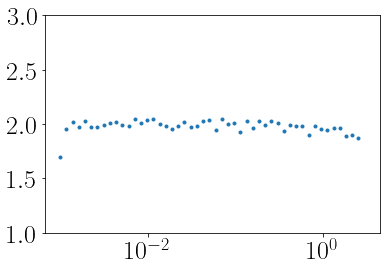

In [27]:
plt.plot(l_var,(ac2-1)/(ac1-1),'.')
plt.xscale('log')
plt.ylim([1,3])